# **Implémentation du modèle**
---

## Introduction

Contrairement au notebook "modèle", ici nous nous intéressons aux chocs de la politique monétaire américaine sur les pays européens.



Ce notebook contient les codes nécessaire à la mise en place du modèle. Le modèle est inspiré de celui de Iacoviello et Navarro : 

- La première étape consiste à identifier les chocs de politique monétaire, en prenant le résidu de la régression du taux d'intérêt sur l'écart d'inflation par rapport à la cible et l'output gap ou le chômage. En réalité Iacoviello et Navarro utilisent des lags et valeurs présentes de l'inflation, des spreads de crédit, du PIB et des lags des taux des fonds fédéraux.
Il nous manque donc l'output gap, l'inflation et le chômage de la zone euro
- La deuxième étape consiste à estimer l'impact de ces chocs sur l'activité économique (PIB, emploi ...) en régressant ces variables sur les chocs et des variables de contrôles (4 lags du PIB et des trends linéaires et quadratiques)

## Formatage des données

In [100]:
# import des données américaines

!pip install openpyxl 
import pandas as pd

sheets_to_load = ["Daily, Close", "Monthly", "Quarterly"]  # Noms des feuilles à importer
dfs = pd.read_excel("../Données_extraites/data_US.xlsx", sheet_name=sheets_to_load, header=0)
# Accéder aux DataFrames importés
dfD = dfs["Daily, Close"]
dfM = dfs["Monthly"]
dfQ = dfs["Quarterly"]

# renommer les variables
dfD.columns = dfD.iloc[0] 
dfD = dfD[1:].reset_index(drop=True)

dfM.columns = dfM.iloc[0] 
dfM = dfM[1:].reset_index(drop=True)


# Il faut trimestrialiser les données (on prend la moyenne)

dfM["date"] = pd.to_datetime(dfM["date"])  # Convertir en datetime
dfM = dfM.set_index("date")  # Définir la colonne "date" comme index
dfM_Q = dfM.resample("Q").mean()  # Appliquer le resample par trimestre

dfD["date"] = pd.to_datetime(dfD["date"])  # Convertir en datetime
dfD = dfD.set_index("date")  # Définir la colonne "date" comme index
dfD_Q = dfD.resample("Q").mean()  # Appliquer le resample par trimestre

# harmoniser les dates
dfD_Q.index = dfD_Q.index.to_period("Q")  
dfM_Q.index = dfM_Q.index.to_period("Q")

dfQ=dfQ.rename(columns={"observation_date":"date"})
dfQ = dfQ.set_index("date")
dfQ.index = dfQ.index.to_period("Q")



/tmp/ipykernel_5351/4245104104.py:25: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dfM_Q = dfM.resample("Q").mean()  # Appliquer le resample par trimestre
/tmp/ipykernel_5351/4245104104.py:29: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dfD_Q = dfD.resample("Q").mean()  # Appliquer le resample par trimestre


In [101]:
import numpy as np
data_US = dfM_Q.merge(dfD_Q, on='date').merge(dfQ, on='date')

# Créer la variable d'inflation (sur 4 trimestres)
data_US["inflation"] = data_US["CPI"].pct_change(periods=4) * 100  # pct_change() donne la variation en pourcentage

# Créer une variable de temps et tendnce quadratique
data_US['time'] = range(1, len(data_US) + 1)
data_US['time_squared'] = data_US['time'] ** 2

# Créer 4 lags pour chaque variable
for col in data_US.columns:
    for lag in range(1, 5):  # Créer les lags 1, 2, 3, 4
        data_US[f"{col}_lag{lag}"] = data_US[col].shift(lag)


# Filtrer les colonnes contenant 'GDP'
gdp_columns = [col for col in data_US.columns if 'GDP' in col]

# Créer de nouvelles colonnes en log pour chaque colonne contenant 'GDP'
for col in gdp_columns:
    data_US[f"{col}_log"] = np.log(data_US[col])



/tmp/ipykernel_5351/3975620391.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_US["inflation"] = data_US["CPI"].pct_change(periods=4) * 100  # pct_change() donne la variation en pourcentage


In [102]:
data_US

,CPI,Policy rate,Industrial production,activité mensualisée,spread corporate,GDPC1,inflation,time,time_squared,CPI_lag1,...,time_lag4,time_squared_lag1,time_squared_lag2,time_squared_lag3,time_squared_lag4,GDPC1_log,GDPC1_lag1_log,GDPC1_lag2_log,GDPC1_lag3_log,GDPC1_lag4_log
date,,,,,,,,,,,,,,,,,,,,,
1996Q4,158.666667,5.28,76.830067,99.577753,0.6,12037.775,NaN,1,1,None,...,NaN,NaN,NaN,NaN,NaN,9.395805,NaN,NaN,NaN,NaN
1997Q1,159.633333,5.276667,78.286233,99.592907,0.591475,12115.472,NaN,2,4,158.666667,...,NaN,1.0,NaN,NaN,NaN,9.402239,9.395805,NaN,NaN,NaN
1997Q2,160.0,5.523333,79.403833,99.823247,0.584615,12317.221,NaN,3,9,159.633333,...,NaN,4.0,1.0,NaN,NaN,9.418754,9.402239,9.395805,NaN,NaN
1997Q3,160.8,5.533333,81.2606,100.017223,0.568308,12471.010,NaN,4,16,160.0,...,NaN,9.0,4.0,1.0,NaN,9.431162,9.418754,9.402239,9.395805,NaN
1997Q4,161.666667,5.506667,83.325533,100.0244,0.667273,12577.495,1.890756,5,25,160.8,...,1.0,16.0,9.0,4.0,1.0,9.439664,9.431162,9.418754,9.402239,9.395805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023Q4,308.158333,5.33,102.6986,100.44725,1.194923,22960.600,3.236199,109,11881,306.042333,...,105.0,11664.0,11449.0,11236.0,11025.0,10.041535,10.033679,10.023021,10.016970,10.010073
2024Q1,310.974333,5.33,102.242767,NaN,0.987969,23053.545,3.247987,110,12100,308.158333,...,106.0,11881.0,11664.0,11449.0,11236.0,10.045575,10.041535,10.033679,10.023021,10.016970
2024Q2,313.095667,5.33,102.8633,NaN,0.914394,23223.906,3.187395,111,12321,310.974333,...,107.0,12100.0,11881.0,11664.0,11449.0,10.052937,10.045575,10.041535,10.033679,10.023021


## Détermination des chocs

In [103]:
data_US.columns

Index(['CPI', 'Policy rate', 'Industrial production', 'activité mensualisée',
       'spread corporate', 'GDPC1', 'inflation', 'time', 'time_squared',
       'CPI_lag1', 'CPI_lag2', 'CPI_lag3', 'CPI_lag4', 'Policy rate_lag1',
       'Policy rate_lag2', 'Policy rate_lag3', 'Policy rate_lag4',
       'Industrial production_lag1', 'Industrial production_lag2',
       'Industrial production_lag3', 'Industrial production_lag4',
       'activité mensualisée_lag1', 'activité mensualisée_lag2',
       'activité mensualisée_lag3', 'activité mensualisée_lag4',
       'spread corporate_lag1', 'spread corporate_lag2',
       'spread corporate_lag3', 'spread corporate_lag4', 'GDPC1_lag1',
       'GDPC1_lag2', 'GDPC1_lag3', 'GDPC1_lag4', 'inflation_lag1',
       'inflation_lag2', 'inflation_lag3', 'inflation_lag4', 'time_lag1',
       'time_lag2', 'time_lag3', 'time_lag4', 'time_squared_lag1',
       'time_squared_lag2', 'time_squared_lag3', 'time_squared_lag4',
       'GDPC1_log', 'GDPC1_lag1_log',

In [104]:
data_US_clean = data_US.dropna()

### 1er essai : modèle avec 4 lags

In [105]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

# Supprimer les lignes avec NaN ou Inf
data_US_clean=data_US_clean.apply(pd.to_numeric, errors='coerce')
# Définition de Y (variable dépendante)
Y = data_US_clean['Policy rate']

# Sélectionner toutes les colonnes sauf 'key_rate' et 'TIME_PERIOD'
X = data_US_clean[['Policy rate_lag1','Policy rate_lag2', 'Policy rate_lag3', 'Policy rate_lag4',
'inflation','inflation_lag1','inflation_lag2', 'inflation_lag3', 'inflation_lag4',
'GDPC1_log', 'GDPC1_lag1_log', 'GDPC1_lag2_log', 'GDPC1_lag3_log','GDPC1_lag4_log',
'spread corporate','spread corporate_lag1', 'spread corporate_lag2','spread corporate_lag3', 'spread corporate_lag4',
'time_squared']]



# Ajouter une constante pour l'intercept dans la régression
X = sm.add_constant(X)

# Régression
model = sm.OLS(Y, X).fit()

# Extraire les résidus comme chocs monétaires
data_US_clean['monetary_shocks'] = model.resid

# Afficher le résumé de la régression
print(model.summary())


with open("regression_results4 US.tex", "w") as f:
    f.write(model.summary().as_latex())

    
# Sauvegarder les résultats dans un fichier CSV
data_US_clean[['time', 'monetary_shocks']].to_csv('identified_monetary_shocks.csv', index=False)

# Exporter les résultats de la régression en latex
with open("regression_results_US.tex", "w") as f:
    f.write(model.summary().as_latex())


                            OLS Regression Results                            
Dep. Variable:            Policy rate   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     280.2
Date:                Sat, 12 Apr 2025   Prob (F-statistic):           1.58e-65
Time:                        13:45:35   Log-Likelihood:                 1.2524
No. Observations:                 101   AIC:                             39.50
Df Residuals:                      80   BIC:                             94.41
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.18

In [106]:
import statsmodels.api as sm
import pandas as pd
from statsmodels.iolib.summary2 import summary_col

# Supprimer les lignes avec NaN ou Inf
data_US_clean = data_US_clean.apply(pd.to_numeric, errors='coerce')

# Définition de Y (variable dépendante)
Y = data_US_clean['Policy rate']

# Sélectionner toutes les colonnes explicatives
X = data_US_clean[['Policy rate_lag1', 'Policy rate_lag2', 'Policy rate_lag3', 'Policy rate_lag4',
                   'inflation', 'inflation_lag1', 'inflation_lag2', 'inflation_lag3', 'inflation_lag4',
                   'GDPC1_log', 'GDPC1_lag1_log', 'GDPC1_lag2_log', 'GDPC1_lag3_log', 'GDPC1_lag4_log',
                   'spread corporate', 'spread corporate_lag1', 'spread corporate_lag2', 
                   'spread corporate_lag3', 'spread corporate_lag4', 'time_squared']]

# Ajouter une constante
X = sm.add_constant(X)

# Régression
model = sm.OLS(Y, X).fit()

# Extraire les résidus comme chocs monétaires
data_US_clean['monetary_shocks'] = model.resid

# Fonction pour ajouter les étoiles de significativité
def significance_stars(pval):
    if pval < 0.01:
        return '***'
    elif pval < 0.05:
        return '**'
    elif pval < 0.1:
        return '*'
    else:
        return ''

# Appliquer la fonction avant de formater les nombres
p_values = model.pvalues.apply(significance_stars)

# Créer un DataFrame des résultats
results_df = pd.DataFrame({
    'Coefficient': model.params.map('{:.4f}'.format) + p_values,
    'Std. Error': model.bse.map('{:.4f}'.format),
    't-Statistic': model.tvalues.map('{:.4f}'.format),
    'P-Value': model.pvalues.map('{:.4f}'.format),
})

# Reformater les résultats pour summary_col
model_summary = summary_col([model], stars=True, float_format="%.4f",
                            model_names=["Régression"],
                            info_dict={'R-squared': lambda x: f"{x.rsquared:.4f}",
                                       'Adj. R-squared': lambda x: f"{x.rsquared_adj:.4f}",
                                       'F-statistic': lambda x: f"{x.fvalue:.2f} (p={x.f_pvalue:.4g})"})

# Exporter le tableau en LaTeX
latex_table = model_summary.as_latex()

with open("regression_results_full_US.tex", "w") as f:
    f.write(latex_table)

# Affichage du tableau final
print(model_summary)


                           Régression    
-----------------------------------------
const                 0.1814             
                      (8.7748)           
Policy rate_lag1      1.6687***          
                      (0.1167)           
Policy rate_lag2      -0.7024***         
                      (0.2355)           
Policy rate_lag3      -0.1986            
                      (0.2396)           
Policy rate_lag4      0.1693             
                      (0.1263)           
inflation             0.0569             
                      (0.0436)           
inflation_lag1        -0.0207            
                      (0.0643)           
inflation_lag2        0.0168             
                      (0.0640)           
inflation_lag3        0.0110             
                      (0.0639)           
inflation_lag4        0.0210             
                      (0.0453)           
GDPC1_log             5.9692**           
                      (2.7764)   

### 2ème essai: modèle avec 2 lags

In [107]:
import pandas as pd
import statsmodels.api as sm

# Supprimer les lignes avec NaN ou Inf
data_US_clean = data_US_clean.apply(pd.to_numeric, errors='coerce')

# Définition de Y (variable dépendante)
Y = data_US_clean['Policy rate']

# Sélectionner toutes les colonnes explicatives
X = data_US_clean[['Policy rate_lag1','Policy rate_lag2',
                   'inflation','inflation_lag1','inflation_lag2', 
                   'GDPC1_log', 'GDPC1_lag1_log', 'GDPC1_lag2_log', 
                   'spread corporate','spread corporate_lag1', 'spread corporate_lag2',
                   'time_squared']]

# Ajouter une constante
X = sm.add_constant(X)

# Régression
model = sm.OLS(Y, X).fit()

# Extraire les résidus comme chocs monétaires
data_US_clean['monetary_shocks'] = model.resid

# Ajouter les étoiles de significativité
def significance_stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.10:
        return '*'
    else:
        return ''

# Construire un DataFrame avec les résultats formatés
coef_table = pd.DataFrame({
    "Coefficient": model.params,
    "Std. Error": model.bse,
    "t-Statistic": model.tvalues,
    "P-Value": model.pvalues
})

# Ajouter les étoiles aux coefficients
coef_table["Significance"] = coef_table["P-Value"].apply(significance_stars)
coef_table["Coefficient"] = coef_table["Coefficient"].round(4).astype(str) + coef_table["Significance"]

# Réorganiser les colonnes pour l'affichage
coef_table = coef_table[["Coefficient", "Std. Error", "t-Statistic", "P-Value"]]

# Renommer les colonnes en ajoutant le format LaTeX pour du texte en gras
coef_table.columns = [r"\textbf{Coefficient}", r"\textbf{Std. Error}", r"\textbf{t-Statistic}", r"\textbf{P-Value}"]

# Ajouter les statistiques globales en haut de la table
stats_dict = {
    r"\textbf{R-squared}": round(model.rsquared, 4),
    r"\textbf{Adj. R-squared}": round(model.rsquared_adj, 4),
    r"\textbf{F-statistic}": round(model.fvalue, 4),
    r"\textbf{Prob (F-statistic)}": round(model.f_pvalue, 4),
    r"\textbf{Observations}": int(model.nobs)
}

# Convertir en DataFrame et transposer pour affichage
stats_table = pd.DataFrame.from_dict(stats_dict, orient='index', columns=["Value"]).T

# Convertir en LaTeX avec statistiques au début
latex_table = stats_table.to_latex(index=False, escape=False) + "\n" + coef_table.to_latex(index=True, escape=False)

# Sauvegarder en fichier .tex
with open("regression_results_2_lags.tex", "w") as f:
    f.write(latex_table)

# Afficher le résumé de la régression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Policy rate   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     480.0
Date:                Sat, 12 Apr 2025   Prob (F-statistic):           1.14e-74
Time:                        13:45:35   Log-Likelihood:                -2.1134
No. Observations:                 101   AIC:                             30.23
Df Residuals:                      88   BIC:                             64.22
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.61

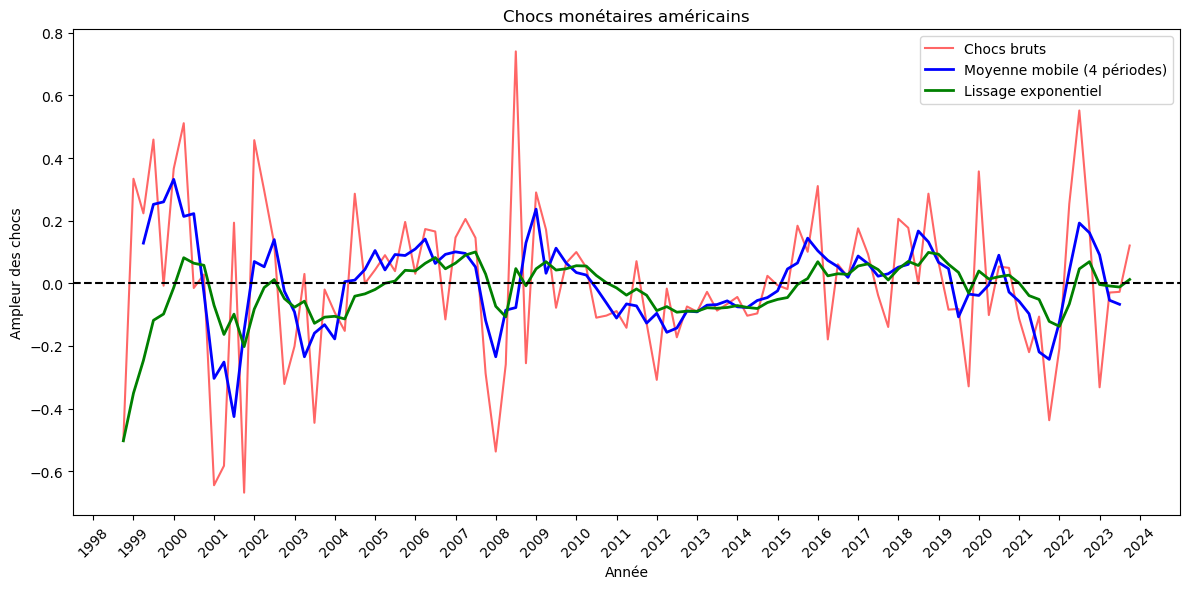

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data_US_clean.index = data_US_clean.index.to_timestamp()


# Appliquer une moyenne glissante sur 6 périodes (ajuster selon les besoins)
data_US_clean['monetary_shocks_smooth'] = data_US_clean['monetary_shocks'].rolling(window=4, center=True).mean()
data_US_clean['monetary_shocks_ewma'] = data_US_clean['monetary_shocks'].ewm(span=10, adjust=False).mean()

# Tracer les séries
plt.figure(figsize=(12, 6))
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks'], color='red', alpha=0.6, label='Chocs bruts')
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_smooth'], color='blue', linewidth=2, label='Moyenne mobile (4 périodes)')
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_ewma'], color='green', linewidth=2, label='Lissage exponentiel')
plt.axhline(0, linestyle="--", color="black")
plt.xlabel('Année')
plt.ylabel('Ampleur des chocs')
plt.title('Chocs monétaires américains')
plt.legend()

# 👉 Personnaliser l'axe des X pour afficher une année tous les ans
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Ticks tous les ans
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format affiché : 2020, 2021, etc.
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("monetary_shocks.png", dpi=300)
plt.show()

### 3ème essai: avec 1 lag

In [109]:
import pandas as pd
import statsmodels.api as sm

# Supprimer les lignes avec NaN ou Inf
data_US_clean = data_US_clean.apply(pd.to_numeric, errors='coerce')

# Définition de Y (variable dépendante)
Y = data_US_clean['Policy rate']

# Sélectionner toutes les colonnes explicatives
X = data_US_clean[['Policy rate_lag1',
                   'inflation','inflation_lag1',
                   'GDPC1_log', 'GDPC1_lag1_log', 
                   'spread corporate','spread corporate_lag1', 
                   'time_squared']]

# Ajouter une constante
X = sm.add_constant(X)

# Régression
model = sm.OLS(Y, X).fit()

# Extraire les résidus comme chocs monétaires
data_US_clean['monetary_shocks_1lag'] = model.resid

# Ajouter les étoiles de significativité
def significance_stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.10:
        return '*'
    else:
        return ''

# Construire un DataFrame avec les résultats formatés
coef_table = pd.DataFrame({
    "Coefficient": model.params,
    "Std. Error": model.bse,
    "t-Statistic": model.tvalues,
    "P-Value": model.pvalues
})

# Ajouter les étoiles aux coefficients
coef_table["Significance"] = coef_table["P-Value"].apply(significance_stars)
coef_table["Coefficient"] = coef_table["Coefficient"].round(4).astype(str) + coef_table["Significance"]

# Réorganiser les colonnes pour l'affichage
coef_table = coef_table[["Coefficient", "Std. Error", "t-Statistic", "P-Value"]]

# Renommer les colonnes en ajoutant le format LaTeX pour du texte en gras
coef_table.columns = [r"\textbf{Coefficient}", r"\textbf{Std. Error}", r"\textbf{t-Statistic}", r"\textbf{P-Value}"]

# Ajouter les statistiques globales en haut de la table
stats_dict = {
    r"\textbf{R-squared}": round(model.rsquared, 4),
    r"\textbf{Adj. R-squared}": round(model.rsquared_adj, 4),
    r"\textbf{F-statistic}": round(model.fvalue, 4),
    r"\textbf{Prob (F-statistic)}": round(model.f_pvalue, 4),
    r"\textbf{Observations}": int(model.nobs)
}

# Convertir en DataFrame et transposer pour affichage
stats_table = pd.DataFrame.from_dict(stats_dict, orient='index', columns=["Value"]).T

# Convertir en LaTeX avec statistiques au début
latex_table = stats_table.to_latex(index=False, escape=False) + "\n" + coef_table.to_latex(index=True, escape=False)

# Sauvegarder en fichier .tex
with open("regression_results_1_lags.tex", "w") as f:
    f.write(latex_table)

# Afficher le résumé de la régression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Policy rate   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     354.5
Date:                Sat, 12 Apr 2025   Prob (F-statistic):           1.24e-65
Time:                        13:45:38   Log-Likelihood:                -39.292
No. Observations:                 101   AIC:                             96.58
Df Residuals:                      92   BIC:                             120.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -10.14

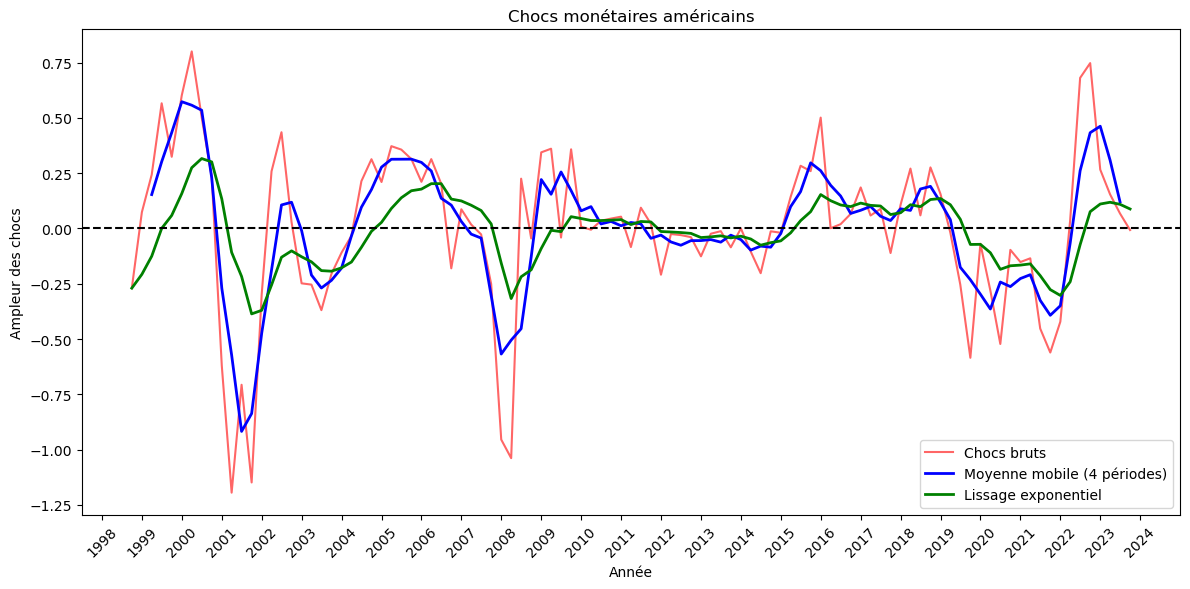

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#data_US_clean.index = data_US_clean.index.to_timestamp()


# Appliquer une moyenne glissante sur 6 périodes (ajuster selon les besoins)
data_US_clean['monetary_shocks_smooth'] = data_US_clean['monetary_shocks_1lag'].rolling(window=4, center=True).mean()
data_US_clean['monetary_shocks_ewma'] = data_US_clean['monetary_shocks_1lag'].ewm(span=10, adjust=False).mean()

# Tracer les séries
plt.figure(figsize=(12, 6))
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_1lag'], color='red', alpha=0.6, label='Chocs bruts')
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_smooth'], color='blue', linewidth=2, label='Moyenne mobile (4 périodes)')
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_ewma'], color='green', linewidth=2, label='Lissage exponentiel')
plt.axhline(0, linestyle="--", color="black")
plt.xlabel('Année')
plt.ylabel('Ampleur des chocs')
plt.title('Chocs monétaires américains')
plt.legend()

# 👉 Personnaliser l'axe des X pour afficher une année tous les ans
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Ticks tous les ans
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format affiché : 2020, 2021, etc.
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("monetary_shocks_1lag.png", dpi=300)
plt.show()

### 4è essai: modèle sans les corporate spreads, avec 2 lags

In [112]:
import pandas as pd
import statsmodels.api as sm

# Supprimer les lignes avec NaN ou Inf
data_US_clean = data_US_clean.apply(pd.to_numeric, errors='coerce')

# Définition de Y (variable dépendante)
Y = data_US_clean['Policy rate']

# Sélectionner toutes les colonnes explicatives
X = data_US_clean[['Policy rate_lag1','Policy rate_lag2',
                   'inflation','inflation_lag1','inflation_lag2', 
                   'GDPC1_log', 'GDPC1_lag1_log', 'GDPC1_lag2_log', 
                   
                   'time_squared']]

# Ajouter une constante
X = sm.add_constant(X)

# Régression
model = sm.OLS(Y, X).fit()

# Extraire les résidus comme chocs monétaires
data_US_clean['monetary_shocks_2lags_v2'] = model.resid

# Ajouter les étoiles de significativité
def significance_stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.10:
        return '*'
    else:
        return ''

# Construire un DataFrame avec les résultats formatés
coef_table = pd.DataFrame({
    "Coefficient": model.params,
    "Std. Error": model.bse,
    "t-Statistic": model.tvalues,
    "P-Value": model.pvalues
})

# Ajouter les étoiles aux coefficients
coef_table["Significance"] = coef_table["P-Value"].apply(significance_stars)
coef_table["Coefficient"] = coef_table["Coefficient"].round(4).astype(str) + coef_table["Significance"]

# Réorganiser les colonnes pour l'affichage
coef_table = coef_table[["Coefficient", "Std. Error", "t-Statistic", "P-Value"]]

# Renommer les colonnes en ajoutant le format LaTeX pour du texte en gras
coef_table.columns = [r"\textbf{Coefficient}", r"\textbf{Std. Error}", r"\textbf{t-Statistic}", r"\textbf{P-Value}"]

# Ajouter les statistiques globales en haut de la table
stats_dict = {
    r"\textbf{R-squared}": round(model.rsquared, 4),
    r"\textbf{Adj. R-squared}": round(model.rsquared_adj, 4),
    r"\textbf{F-statistic}": round(model.fvalue, 4),
    r"\textbf{Prob (F-statistic)}": round(model.f_pvalue, 4),
    r"\textbf{Observations}": int(model.nobs)
}

# Convertir en DataFrame et transposer pour affichage
stats_table = pd.DataFrame.from_dict(stats_dict, orient='index', columns=["Value"]).T

# Convertir en LaTeX avec statistiques au début
latex_table = stats_table.to_latex(index=False, escape=False) + "\n" + coef_table.to_latex(index=True, escape=False)

# Sauvegarder en fichier .tex
with open("regression_results_2_lags_v2.tex", "w") as f:
    f.write(latex_table)

# Afficher le résumé de la régression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Policy rate   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     570.7
Date:                Sat, 12 Apr 2025   Prob (F-statistic):           5.50e-76
Time:                        13:45:52   Log-Likelihood:                -9.4795
No. Observations:                 101   AIC:                             38.96
Df Residuals:                      91   BIC:                             65.11
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                7.1924      7.836  

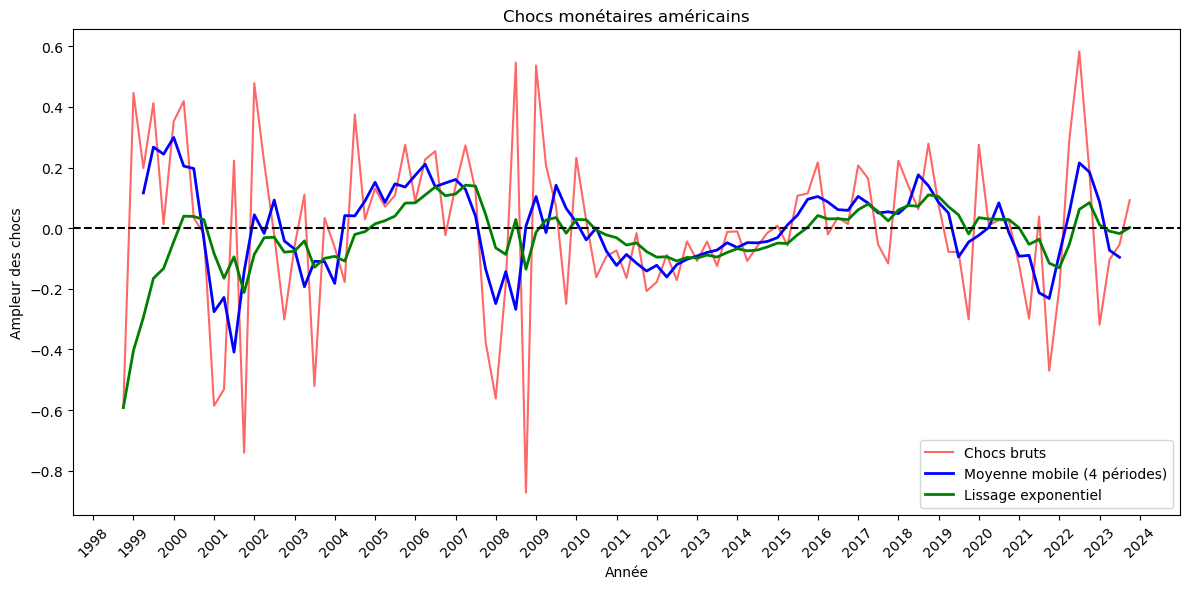

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#data_US_clean.index = data_US_clean.index.to_timestamp()


# Appliquer une moyenne glissante sur 6 périodes (ajuster selon les besoins)
data_US_clean['monetary_shocks_smooth'] = data_US_clean['monetary_shocks_2lags_v2'].rolling(window=4, center=True).mean()
data_US_clean['monetary_shocks_ewma'] = data_US_clean['monetary_shocks_2lags_v2'].ewm(span=10, adjust=False).mean()

# Tracer les séries
plt.figure(figsize=(12, 6))
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_2lags_v2'], color='red', alpha=0.6, label='Chocs bruts')
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_smooth'], color='blue', linewidth=2, label='Moyenne mobile (4 périodes)')
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_ewma'], color='green', linewidth=2, label='Lissage exponentiel')
plt.axhline(0, linestyle="--", color="black")
plt.xlabel('Année')
plt.ylabel('Ampleur des chocs')
plt.title('Chocs monétaires américains')
plt.legend()

# 👉 Personnaliser l'axe des X pour afficher une année tous les ans
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Ticks tous les ans
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format affiché : 2020, 2021, etc.
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("monetary_shocks_2lags_v2.png", dpi=300)
plt.show()

### 5ème essai: sans l'inflation, avec 2 lags

In [115]:
import pandas as pd
import statsmodels.api as sm

# Supprimer les lignes avec NaN ou Inf
data_US_clean = data_US_clean.apply(pd.to_numeric, errors='coerce')

# Définition de Y (variable dépendante)
Y = data_US_clean['Policy rate']

# Sélectionner toutes les colonnes explicatives
X = data_US_clean[['Policy rate_lag1','Policy rate_lag2',
                   
                   'GDPC1_log', 'GDPC1_lag1_log', 'GDPC1_lag2_log', 
                   'spread corporate','spread corporate_lag1', 'spread corporate_lag2',
                   'time_squared']]

# Ajouter une constante
X = sm.add_constant(X)

# Régression
model = sm.OLS(Y, X).fit()

# Extraire les résidus comme chocs monétaires
data_US_clean['monetary_shocks_2lags_v3'] = model.resid

# Ajouter les étoiles de significativité
def significance_stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.10:
        return '*'
    else:
        return ''

# Construire un DataFrame avec les résultats formatés
coef_table = pd.DataFrame({
    "Coefficient": model.params,
    "Std. Error": model.bse,
    "t-Statistic": model.tvalues,
    "P-Value": model.pvalues
})

# Ajouter les étoiles aux coefficients
coef_table["Significance"] = coef_table["P-Value"].apply(significance_stars)
coef_table["Coefficient"] = coef_table["Coefficient"].round(4).astype(str) + coef_table["Significance"]

# Réorganiser les colonnes pour l'affichage
coef_table = coef_table[["Coefficient", "Std. Error", "t-Statistic", "P-Value"]]

# Renommer les colonnes en ajoutant le format LaTeX pour du texte en gras
coef_table.columns = [r"\textbf{Coefficient}", r"\textbf{Std. Error}", r"\textbf{t-Statistic}", r"\textbf{P-Value}"]

# Ajouter les statistiques globales en haut de la table
stats_dict = {
    r"\textbf{R-squared}": round(model.rsquared, 4),
    r"\textbf{Adj. R-squared}": round(model.rsquared_adj, 4),
    r"\textbf{F-statistic}": round(model.fvalue, 4),
    r"\textbf{Prob (F-statistic)}": round(model.f_pvalue, 4),
    r"\textbf{Observations}": int(model.nobs)
}

# Convertir en DataFrame et transposer pour affichage
stats_table = pd.DataFrame.from_dict(stats_dict, orient='index', columns=["Value"]).T

# Convertir en LaTeX avec statistiques au début
latex_table = stats_table.to_latex(index=False, escape=False) + "\n" + coef_table.to_latex(index=True, escape=False)

# Sauvegarder en fichier .tex
with open("regression_results_2_lags_v3.tex", "w") as f:
    f.write(latex_table)

# Afficher le résumé de la régression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Policy rate   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     576.0
Date:                Sat, 12 Apr 2025   Prob (F-statistic):           3.63e-76
Time:                        13:46:10   Log-Likelihood:                -9.0186
No. Observations:                 101   AIC:                             38.04
Df Residuals:                      91   BIC:                             64.19
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.26

## 2ème partie du modèle: impact des chocs monétaires

Nous allons maintenant estimer avec une régression de panel l'impact des chocs de politique monétaire identifiés, sur différentes variables (GDP, employment ? ...). La méthode utilisé est celle de Jorda (2005), la méthode de projection locale. Cela consiste à "estimer des projections locales à chaque période au lieu d'extrapoler sur des horizons lointains à partir d'un modèle."
Nous allons estimer une équation de la forme suivante, comme dans Iacoviello & Navarro (2018) :

$$
y_{i,t+h} = \alpha_{i,h} + \beta_h u_t + A_{h,i} Z_{i,t} + \varepsilon_{i,t+h}
$$

où :

- $y_{i,t+h}$ est le PIB du pays $ i $ au temps $t$,
- $\alpha_{i,h} $ est un effet fixe spécifique au pays,
- $u_t$ est le choc monétaire,
- $Z_{i,t}$  représente les variables de contrôle : 4 lags du PIB, des tendances linéaire et quadratique,
- $\varepsilon_{i,t+h}$  est le terme d'erreur.

Pour chaque h il faut estimer un $\beta_h$, ensuite il faut faire les IRF (fonctions de réponse impulsionnelle) pour les différents Y qu'on utilise.


Pour les variables de contrôle, il faut sûrement tester lesquelles sont les meilleures, ne pas forcément reproduire exactement le modèle.

On a des données trimestrielles donc on prend h de 0 à 4 ou 8

In [116]:
import pandas as pd
data=pd.read_excel("../Données_produites/base_de_données_v1.xlsx")

In [117]:
# 🔍 Étape 1 : Vérification des colonnes
print("Colonnes initiales :", data.columns.tolist())

# Identifier automatiquement la colonne temporelle si nommée "Unnamed: 0" ou similaire
time_col_candidates = [col for col in data.columns if "unnamed" in col.lower() or "time" in col.lower()]
if time_col_candidates:
    time_col = time_col_candidates[0]
    data = data.rename(columns={time_col: "Time"})
else:
    raise ValueError("Impossible de trouver la colonne 'Time' dans le fichier Excel.")

# 🔁 Étape 2 : Conversion au format long
df_long = data.melt(id_vars="Time", var_name="Variable_Country", value_name="Value")

# 🔍 Étape 3 : Vérification du format des noms
# Affiche quelques exemples pour s’assurer du format attendu
print("\nExemples de noms de colonnes fusionnées :", df_long["Variable_Country"].unique()[:5])

# Appliquer un split seulement si un underscore est présent
split_ok = df_long["Variable_Country"].str.contains("_")
df_valid = df_long[split_ok].copy()

# Séparer en deux colonnes : Variable + Country
df_valid[["Variable", "Country"]] = df_valid["Variable_Country"].str.rsplit("_", n=1, expand=True)

# ⚠️ Facultatif : alerter sur les noms qui n'ont pas pu être séparés
if not split_ok.all():
    print("Colonnes ignorées car mal nommées :", df_long.loc[~split_ok, "Variable_Country"].unique())

# Réorganiser les colonnes
df_final = df_valid[["Time", "Country", "Variable", "Value"]]

# ✅ Affichage final
print("\nAperçu du DataFrame long format :")
print(df_final.head())

# Sauvegarde dans data pour compatibilité avec le reste de ton notebook
data = df_final.copy()


Colonnes initiales : ['Unnamed: 0', 'CPI_Austria', 'PIB_Austria', 'LT_IR_Austria', 'ST_IR_Austria', 'WH_Austria', 'P_Growth_Austria', 'CPI_Belgium', 'PIB_Belgium', 'LT_IR_Belgium', 'ST_IR_Belgium', 'WH_Belgium', 'P_Growth_Belgium', 'CPI_Bulgaria', 'PIB_Bulgaria', 'LT_IR_Bulgaria', 'ST_IR_Bulgaria', 'WH_Bulgaria', 'P_Growth_Bulgaria', 'CPI_Czechia', 'PIB_Czechia', 'LT_IR_Czechia', 'ST_IR_Czechia', 'WH_Czechia', 'P_Growth_Czechia', 'CPI_Denmark', 'PIB_Denmark', 'LT_IR_Denmark', 'ST_IR_Denmark', 'WH_Denmark', 'P_Growth_Denmark', 'CPI_Estonia', 'PIB_Estonia', 'LT_IR_Estonia', 'ST_IR_Estonia', 'WH_Estonia', 'P_Growth_Estonia', 'CPI_Finland', 'PIB_Finland', 'LT_IR_Finland', 'ST_IR_Finland', 'WH_Finland', 'P_Growth_Finland', 'CPI_France', 'PIB_France', 'LT_IR_France', 'ST_IR_France', 'WH_France', 'P_Growth_France', 'CPI_Germany', 'PIB_Germany', 'LT_IR_Germany', 'ST_IR_Germany', 'WH_Germany', 'P_Growth_Germany', 'CPI_Greece', 'PIB_Greece', 'LT_IR_Greece', 'ST_IR_Greece', 'WH_Greece', 'P_Growth

In [ ]:
#data
#df_target

,Time,Country,Variable,Value,lag1,lag2,lag3,lag4,trend,trend_sq,Category
120,1995-Q1,Austria,PIB,10.673286,NaN,NaN,NaN,NaN,1,1,Petite économie développée
121,1995-Q2,Austria,PIB,10.753356,10.673286,NaN,NaN,NaN,2,4,Petite économie développée
122,1995-Q3,Austria,PIB,10.743664,10.753356,10.673286,NaN,NaN,3,9,Petite économie développée
123,1995-Q4,Austria,PIB,10.765584,10.743664,10.753356,10.673286,NaN,4,16,Petite économie développée
124,1996-Q1,Austria,PIB,10.706412,10.765584,10.743664,10.753356,10.673286,5,25,Petite économie développée
...,...,...,...,...,...,...,...,...,...,...,...
18955,2023-Q4,Switzerland,PIB,12.272744,12.245392,12.229858,12.209325,12.237036,116,13456,Petite économie développée
18956,2024-Q1,Switzerland,PIB,12.268844,12.272744,12.245392,12.229858,12.209325,117,13689,Petite économie développée
18957,2024-Q2,Switzerland,PIB,12.263684,12.268844,12.272744,12.245392,12.229858,118,13924,Petite économie développée
18958,2024-Q3,Switzerland,PIB,12.286981,12.263684,12.268844,12.272744,12.245392,119,14161,Petite économie développée


Réponse PIB américain aux chocs monétaires

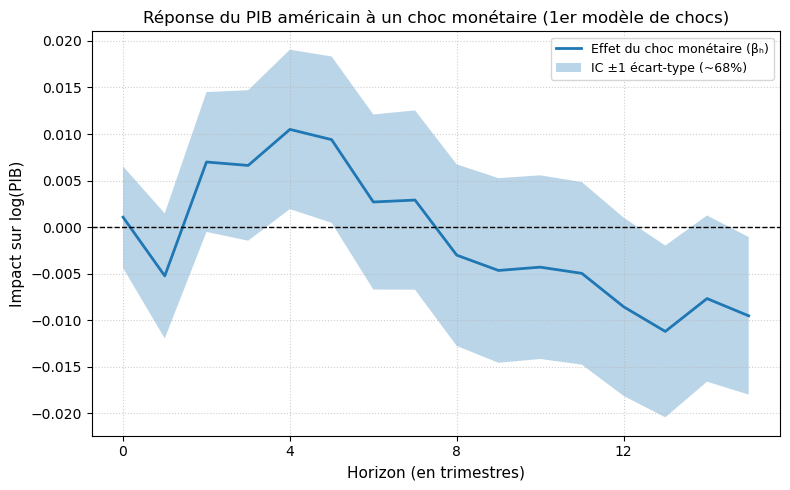

In [119]:
# ==============================
# 1) Paramètres et initialisation
# ==============================
H = 15  # nombre maximal d'horizons
betas = []
stderr_list = []

# ==============================
# 2) Boucle sur les horizons h = 0 à H
# ==============================
for h in range(H + 1):
    # Copie du DataFrame pour chaque horizon (pour éviter des colonnes temporaires cumulées)
    df = data_US_clean.copy()

    # a) Création des lags du PIB
    for lag in range(1, 5):
        df[f'GDP_lag{lag}'] = df['GDPC1_log'].shift(lag)

    # b) Ajout d'une tendance linéaire et quadratique
    df['trend'] = range(len(df))
    df['trend_sq'] = df['trend'] ** 2

    # c) Variable dépendante : PIB à l’horizon h (décalage de -h)
    df[f'GDP_lead_{h}'] = df['GDPC1_log'].shift(-h)

    # d) Nettoyage des lignes NaN (pour éviter de perdre l'équation)
    df_model = df.dropna(subset=[
        f'GDP_lead_{h}',        # la variable dépendante (PIB décalé)
        'monetary_shocks',
        'GDP_lag1', 'GDP_lag2', 'GDP_lag3', 'GDP_lag4'
    ])

    # e) Variable dépendante et explicatives
    Y = df_model[f'GDP_lead_{h}']
    X = df_model[['monetary_shocks', 
                  'GDP_lag1', 'GDP_lag2', 'GDP_lag3', 'GDP_lag4',
                  'trend', 'trend_sq']]
    X = sm.add_constant(X)

    # f) Estimation de la régression OLS pour l’horizon h
    model = sm.OLS(Y, X).fit()

    # g) Extraction du coefficient du choc et de son écart-type
    beta_h = model.params['monetary_shocks']
    stderr_h = model.bse['monetary_shocks']

    # h) Stockage
    betas.append(beta_h)
    stderr_list.append(stderr_h)

# ======================================
# 3) Calcul d'un intervalle de confiance (IC 68%)
#    (Pour 1 écart-type, ≈ 68% si distribution normale)
# ======================================
lower = [b - s for b, s in zip(betas, stderr_list)]
upper = [b + s for b, s in zip(betas, stderr_list)]

# ======================================
# 4) Tracé de la Fonction de Réponse (IRF)
# ======================================
horizons = range(H + 1)

plt.figure(figsize=(8, 5))

# Courbe principale : coefficient βᵣ
plt.plot(horizons, betas, linewidth=2, label="Effet du choc monétaire (βₕ)")

# Intervalle de confiance
plt.fill_between(horizons, lower, upper, alpha=0.3, label="IC ±1 écart-type (~68%)")

# Ligne horizontale à 0
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Mise en forme
plt.title("Réponse du PIB américain à un choc monétaire (1er modèle de chocs)", fontsize=12)
plt.xlabel("Horizon (en trimestres)", fontsize=11)
plt.ylabel("Impact sur log(PIB)", fontsize=11)
plt.xticks(np.arange(0, H+1, step=4))
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc="best", fontsize=9)
plt.tight_layout()
plt.savefig("reponse US gdp1.png", dpi=300)
plt.show()


Réponses des taux obligataires/corpo aux chocs

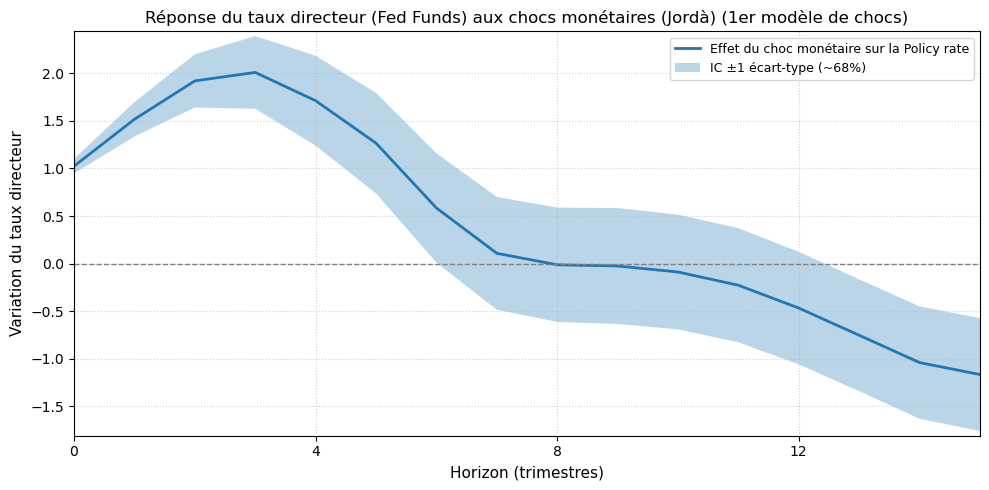

In [121]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ===============================
# 1) Paramètres de la projection
# ===============================
H = 15  # horizon maximal (en trimestres)
betas = []
stderr_list = []

# ===============================
# 2) Boucle sur les horizons h
# ===============================
for h in range(H + 1):
    # Copie pour éviter d'empiler les colonnes d'un tour à l'autre
    df = data_US_clean.copy()

    # ------------------------------
    # a) Création des lags du taux directeur
    # ------------------------------
    for lag in range(1, 5):
        df[f'rate_lag{lag}'] = df['Policy rate'].shift(lag)

    # ------------------------------
    # b) Tendance linéaire + quadratique (contrôle)
    # ------------------------------
    df['trend'] = range(len(df))
    df['trend_sq'] = df['trend'] ** 2

    # ------------------------------
    # c) Variable dépendante : taux à l'horizon h
    #    => Policy rate au temps t+h
    # ------------------------------
    df[f'rate_lead_{h}'] = df['Policy rate'].shift(-h)

    # ------------------------------
    # d) Sous-échantillon sans NaN
    # ------------------------------
    df_model = df.dropna(subset=[
        f'rate_lead_{h}',      # la variable dépendante
        'monetary_shocks',  # votre choc monétaire
        'rate_lag1', 'rate_lag2', 'rate_lag3', 'rate_lag4'
    ])

    # ------------------------------
    # e) Construction de Y et X
    # ------------------------------
    Y = df_model[f'rate_lead_{h}']  # le Policy rate à horizon h
    X = df_model[['monetary_shocks',
                  'rate_lag1', 'rate_lag2', 'rate_lag3', 'rate_lag4',
                  'trend', 'trend_sq']]

    X = sm.add_constant(X)

    # ------------------------------
    # f) Estimation OLS
    # ------------------------------
    model = sm.OLS(Y, X).fit()

    # ------------------------------
    # g) Récupération du coefficient + écart-type
    # ------------------------------
    beta = model.params['monetary_shocks']
    stderr = model.bse['monetary_shocks']

    betas.append(beta)
    stderr_list.append(stderr)

# ==============================================
# 3) Construction d'un Intervalle de Confiance (IC)
#    On prend +/- 1 écart-type (approximatif 68%)
# ==============================================
lower = [b - s for b, s in zip(betas, stderr_list)]
upper = [b + s for b, s in zip(betas, stderr_list)]

# ==============================================
# 4) Tracé de la "réponse impulsionnelle" (Local Projections)
# ==============================================
horizons = range(H + 1)
y_min = min(lower) - 0.05
y_max = max(upper) + 0.05

plt.figure(figsize=(10, 5))

# Courbe principale : coefficients βₕ
plt.plot(horizons, betas, linewidth=2, label="Effet du choc monétaire sur la Policy rate")

# IC 68%
plt.fill_between(horizons, lower, upper, alpha=0.3, label="IC ±1 écart-type (~68%)")

# Ligne horizontale = 0
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Paramètres du graphique
plt.title("Réponse du taux directeur (Fed Funds) aux chocs monétaires (Jordà) (1er modèle de chocs)", fontsize=12)
plt.xlabel("Horizon (trimestres)", fontsize=11)
plt.ylabel("Variation du taux directeur", fontsize=11)

plt.ylim(y_min, y_max)
plt.xlim(0, H)
plt.xticks(np.arange(0, H+1, 4))
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc="best", fontsize=9)
plt.tight_layout()
plt.savefig("reponse US taux_dir.png", dpi=300)
plt.show()


Réponse des PIBs des pays européens aux chocs

In [122]:
categories = {
    "Économie en développement": [
        "Czechia", "Lithuania", "Latvia", "Poland", "Bulgaria", "Slovakia",
        "Hungary", "Slovenia", "Iceland", "Estonia", "Romania"
    ],
    "Grosse économie développée": [
        "Germany", "United Kingdom", "France", "Italy", "Spain", "Netherlands"
    ],
    "Petite économie développée": [
        "Austria", "Belgium", "Denmark", "Greece", "Finland", "Ireland",
        "Luxembourg", "Norway", "Portugal", "Sweden", "Switzerland"
    ]
}

/tmp/ipykernel_5351/2697340299.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_target["Time"] = pd.to_datetime(df_target["Time"])



📋 Résultats par pays :
        Country                    Category  Coef_monetary_shock   P_value  \
11      Iceland   Économie en développement             0.080041  0.040956   
5       Estonia   Économie en développement             0.018406  0.401288   
12      Ireland  Petite économie développée             0.010867  0.547344   
14       Latvia   Économie en développement             0.008974  0.781391   
4       Denmark  Petite économie développée             0.006238  0.551639   
21      Romania   Économie en développement             0.006222  0.879361   
20     Portugal  Petite économie développée             0.005975  0.668567   
3       Czechia   Économie en développement             0.005274  0.816296   
25       Sweden  Petite économie développée             0.000420  0.977752   
0       Austria  Petite économie développée             0.000269  0.982561   
22     Slovakia   Économie en développement            -0.000810  0.969241   
16   Luxembourg  Petite économie dévelop

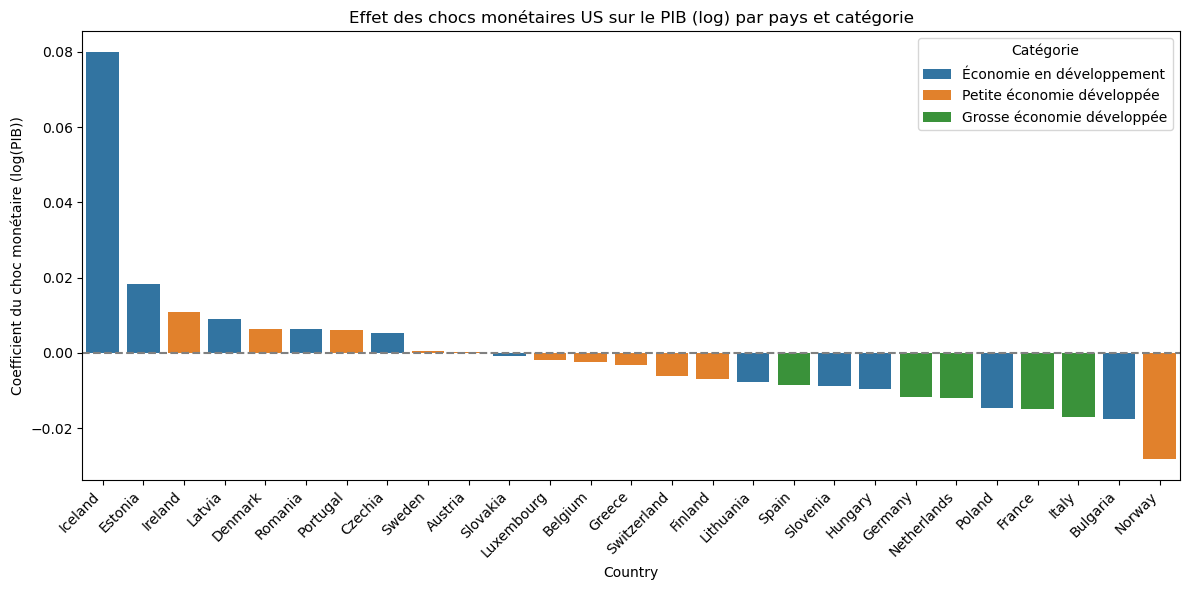

In [ ]:
import seaborn as sns
def get_category(country):
    for cat, countries in categories.items():
        if country in countries:
            return cat
    return "Autre"

# --- 2. Filtrer les données sur le PIB et prendre le log ---
target_variable = "PIB"
df_target = data[data["Variable"] == target_variable].copy()
df_target = df_target[df_target["Value"] > 0]  # sécurité pour log
df_target["Value"] = np.log(df_target["Value"])

# --- 3. Trier et ajouter lags + tendances ---
df_target = df_target.sort_values(["Country", "Time"])

for lag in range(1, 5):
    df_target[f"lag{lag}"] = df_target.groupby("Country")["Value"].shift(lag)

df_target["trend"] = df_target.groupby("Country").cumcount() + 1
df_target["trend_sq"] = df_target["trend"] ** 2
df_target["Category"] = df_target["Country"].apply(get_category)

# Il faut merger ces données avec les chocs monétaires obtenus : 
data_US_clean_reset = data_US_clean.reset_index()
monetary_cols = [col for col in data_US_clean_reset.columns if col.startswith("monetary_shocks")]
monetary_df = data_US_clean_reset[["date"] + monetary_cols].copy()
monetary_df = monetary_df.rename(columns={"date": "Time"})
df_target["Time"] = pd.to_datetime(df_target["Time"])
monetary_df["Time"] = pd.to_datetime(monetary_df["Time"])

df_target = df_target.merge(monetary_df, on="Time", how="left")



# --- 4. Régressions pays par pays ---
results = []
required_cols = ["Value", "monetary_shocks", "lag1", "lag2", "lag3", "lag4", "trend", "trend_sq"]

for country in df_target["Country"].unique():
    sub = df_target[df_target["Country"] == country].dropna(subset=required_cols)

    if len(sub) < 10:
        continue

    X = sub[["monetary_shocks", "lag1", "lag2", "lag3", "lag4", "trend", "trend_sq"]]
    X = sm.add_constant(X)
    y = sub["Value"]

    model = sm.OLS(y, X).fit()
    coef = model.params["monetary_shocks"]
    pval = model.pvalues["monetary_shocks"]
    category = get_category(country)

    results.append({
        "Country": country,
        "Category": category,
        "Coef_monetary_shock": coef,
        "P_value": pval,
        "R_squared": model.rsquared
    })



# --- 5. Résultats ---
results_df = pd.DataFrame(results).sort_values("Coef_monetary_shock", ascending=False)

print("\n📋 Résultats par pays :")
print(results_df)

# --- 6. Graphique groupé par catégorie ---
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Country", y="Coef_monetary_shock", hue="Category", dodge=False)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Effet des chocs monétaires US sur le PIB (log) par pays et catégorie")
plt.ylabel("Coefficient du choc monétaire (log(PIB))")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Catégorie")
plt.tight_layout()
plt.show()

IRF des pays européens

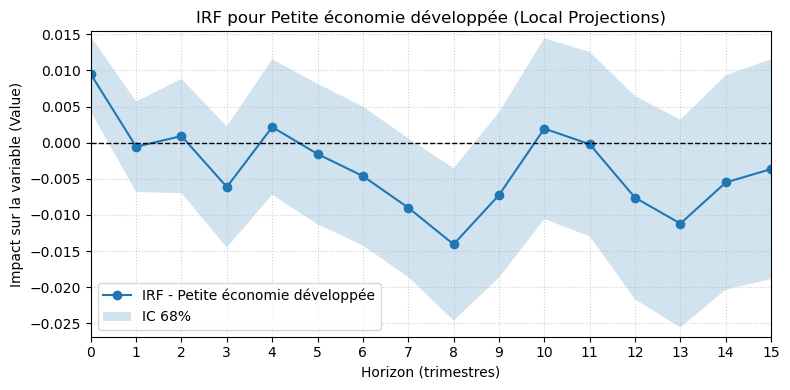

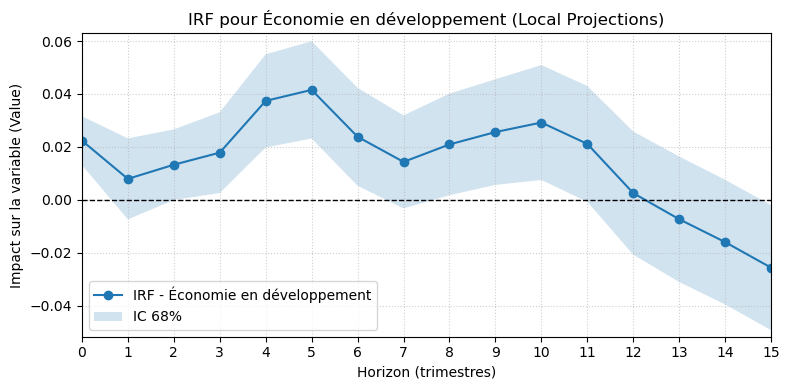

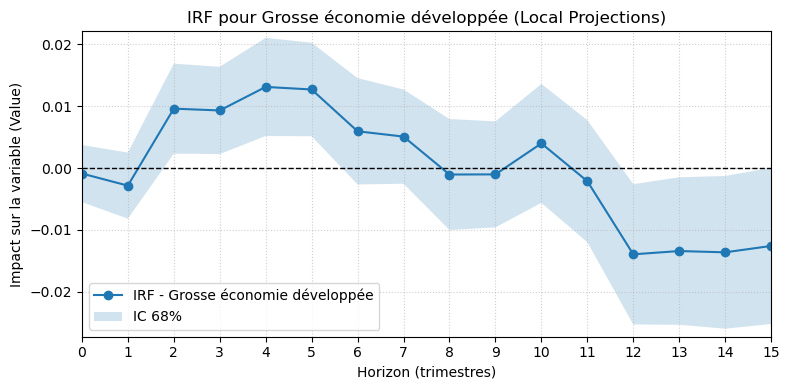

In [145]:
# ===================================
# 1) Paramètres
# ===================================
horizons = range(16)  # de 0 à 15
# df_target : votre DataFrame contenant déjà
#  - "Value"         = la variable d'intérêt (ex: log(PIB) ou autre)
#  - "Category"      = la catégorie (classement que vous utilisez)
#  - "Country"       = le pays
#  - "monetary_shocks_2lags_v3" = votre choc monétaire US
#  - un index temporel ou au moins un ordre temporel implicite

# On crée des structures pour stocker les IRFs par catégorie :
results_irf_cat = {cat: [] for cat in df_target["Category"].unique()}
conf_ints_cat = {cat: [] for cat in df_target["Category"].unique()}

# ===================================
# 2) Estimation des IRF par catégorie et par horizon
# ===================================
for h in horizons:
    # -----------------------------------
    # a) On crée un DataFrame temporaire
    #    avec la variable dépendante "lead h"
    # -----------------------------------
    df_shifted = df_target.copy()

    # Pour chaque pays, on décale Value de -h
    df_shifted[f"lead_{h}"] = df_shifted.groupby("Country")["Value"].shift(-h)

    # On crée les lags 1 à 4 de la variable Value
    for lag in range(1, 5):
        df_shifted[f"lag{lag}"] = df_shifted.groupby("Country")["Value"].shift(lag)

    # Tendance linéaire + quadratique (par pays)
    df_shifted["trend"] = df_shifted.groupby("Country").cumcount() + 1
    df_shifted["trend_sq"] = df_shifted["trend"] ** 2

    # -----------------------------------
    # b) Pour chaque catégorie, on estime la régression:
    #    lead_{h} = alpha + beta_h * Shock_t + sum_{p=1}^4 gamma_p * lag p + ...
    # -----------------------------------
    for cat in results_irf_cat.keys():
        # Filtrer la catégorie
        sub = df_shifted[df_shifted["Category"] == cat].dropna(
            subset=[
                f"lead_{h}",
                "monetary_shocks_2lags_v3",
                "lag1", "lag2", "lag3", "lag4",
                "trend", "trend_sq"
            ]
        )

        # S'il y a trop peu d'observations, on saute
        if len(sub) < 10:
            results_irf_cat[cat].append(np.nan)
            conf_ints_cat[cat].append((np.nan, np.nan))
            continue

        # Variables dépendante / explicatives
        Y = sub[f"lead_{h}"]
        X = sub[[
            "monetary_shocks_2lags_v3",
            "lag1", "lag2", "lag3", "lag4",
            "trend", "trend_sq"
        ]]
        X = sm.add_constant(X)

        # Régression OLS (avec erreurs st. robustes type HC1)
        model = sm.OLS(Y, X).fit(cov_type='HC1')

        # Extraction du coefficient du choc + son écart-type
        beta = model.params["monetary_shocks_2lags_v3"]
        stderr = model.bse["monetary_shocks_2lags_v3"]

        # Stockage de la valeur ponctuelle et de l'IC (68% ≈ ±1 écart-type)
        results_irf_cat[cat].append(beta)
        conf_ints_cat[cat].append((beta - stderr, beta + stderr))

# ===================================
# 3) Affichage des IRFs catégorie par catégorie
# ===================================
for cat in results_irf_cat:
    irf = results_irf_cat[cat]         # la suite des betas pour h = 0..15
    ci = np.array(conf_ints_cat[cat])  # la suite des IC

    # Vérifie s’il n’y a que des NaN (pas assez de données)
    if all(np.isnan(irf)):
        print(f"⏭️  Pas assez de données pour {cat}")
        continue

    lower, upper = ci[:, 0], ci[:, 1]

    # Définir des bornes dynamiques, en évitant le cas all-NaN
    valid_lower = lower[~np.isnan(lower)]
    valid_upper = upper[~np.isnan(upper)]
    if len(valid_lower) == 0 or len(valid_upper) == 0:
        print(f"⏭️  Pas assez de données valides pour {cat}")
        continue

    y_min = valid_lower.min() - 0.05*abs(valid_lower.min())
    y_max = valid_upper.max() + 0.05*abs(valid_upper.max())

    # Tracé de l'IRF
    plt.figure(figsize=(8, 4))
    plt.plot(horizons, irf, marker='o', label=f"IRF - {cat}")
    plt.fill_between(horizons, lower, upper, alpha=0.2, label="IC 68%")
    plt.axhline(0, color='black', linestyle='--', linewidth=1)

    plt.title(f"IRF pour {cat} (Local Projections)")
    plt.xlabel("Horizon (trimestres)")
    plt.ylabel("Impact sur la variable (Value)")
    plt.ylim(y_min, y_max)
    plt.xlim(0, max(horizons))
    plt.xticks(horizons)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


Regression panel pour IRF PIB étrangers

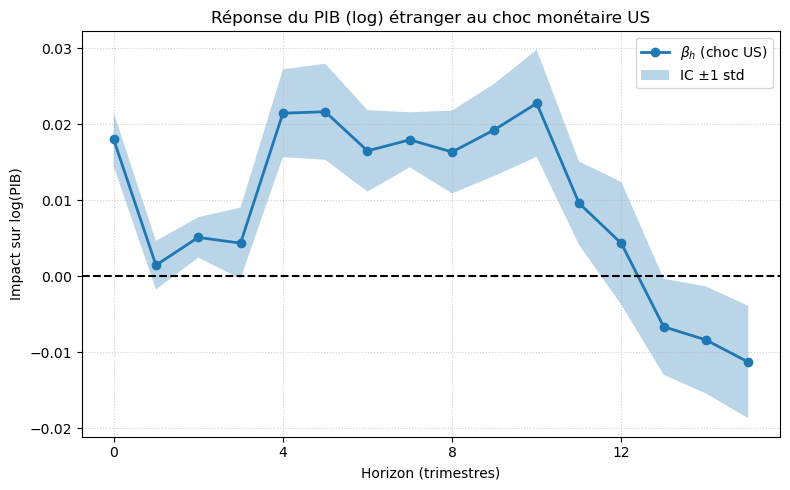

In [120]:
from linearmodels.panel import PanelOLS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------
# 0) Préparer les chocs monétaires US
# ------------------------------------------------
df_shocks = data_US_clean.reset_index()[["date", "monetary_shocks_2lags_v3"]].copy()
df_shocks = df_shocks.rename(columns={"date": "Time", "monetary_shocks_2lags_v3": "shock_US"})

# Convertir Time en datetime avec période trimestrielle correcte
df_shocks["Time"] = pd.PeriodIndex(df_shocks["Time"], freq="Q").to_timestamp()

# ------------------------------------------------
# 1) Corriger le format de data["Time"] → datetime trimestriel
# Nettoie et convertit "1995-Q1" → "1995Q1" → datetime
data["Time"] = data["Time"].astype(str).str.replace("-", "")
data["Time"] = pd.PeriodIndex(data["Time"], freq="Q").to_timestamp()


# ------------------------------------------------
# 2) Fusion avec les chocs
# ------------------------------------------------
df_merged = pd.merge(data, df_shocks, on="Time", how="inner")

# ------------------------------------------------
# 3) Filtrer le PIB (log)
# ------------------------------------------------
df_pib = df_merged[df_merged["Variable"] == "PIB"].copy()
df_pib = df_pib[df_pib["Value"] > 0]
df_pib["Value"] = np.log(df_pib["Value"])

# ------------------------------------------------
# 4) Panel index + sécurité Time
# ------------------------------------------------
df_pib = df_pib.sort_values(["Country", "Time"]).copy()
df_pib["Time"] = pd.to_datetime(df_pib["Time"])  # sécurité explicite
df_pib = df_pib.set_index(["Country", "Time"])

# ------------------------------------------------
# 5) Projections locales façon Jordà
# ------------------------------------------------
H = 15
betas = []
stderr = []

for h in range(H + 1):
    df_lp = df_pib.copy()
    df_lp[f"y_lead{h}"] = df_lp.groupby(level="Country")["Value"].shift(-h)

    for lag in range(1, 5):
        df_lp[f"y_lag{lag}"] = df_lp.groupby(level="Country")["Value"].shift(lag)

    df_lp = df_lp.reset_index()
    df_lp["trend"] = df_lp.groupby("Country").cumcount() + 1
    df_lp["trend_sq"] = df_lp["trend"] ** 2
    df_lp = df_lp.set_index(["Country", "Time"])

    needed = [f"y_lead{h}", "shock_US"] + [f"y_lag{k}" for k in range(1, 5)]
    df_model = df_lp.dropna(subset=needed).copy()

    Y = df_model[f"y_lead{h}"]
    X_cols = ["shock_US", "y_lag1", "y_lag2", "y_lag3", "y_lag4", "trend", "trend_sq"]
    df_model["const"] = 1.0
    X_cols = ["const"] + X_cols

    model = PanelOLS(dependent=Y, exog=df_model[X_cols], entity_effects=True)
    res = model.fit(cov_type="clustered", cluster_entity=True)

    betas.append(res.params["shock_US"])
    stderr.append(res.std_errors["shock_US"])

# ------------------------------------------------
# 6) Tracé de l'IRF
# ------------------------------------------------
betas = np.array(betas)
stderr = np.array(stderr)
lower = betas - stderr
upper = betas + stderr

horizons = range(H + 1)
plt.figure(figsize=(8, 5))
plt.plot(horizons, betas, marker='o', linewidth=2, label=r"$\beta_h$ (choc US)")
plt.fill_between(horizons, lower, upper, alpha=0.3, label="IC ±1 std")
plt.axhline(0, color='black', linestyle='--')
plt.title("Réponse du PIB (log) étranger au choc monétaire US", fontsize=12)
plt.xlabel("Horizon (trimestres)")
plt.ylabel("Impact sur log(PIB)")
plt.xticks(np.arange(0, H + 1, 4))
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


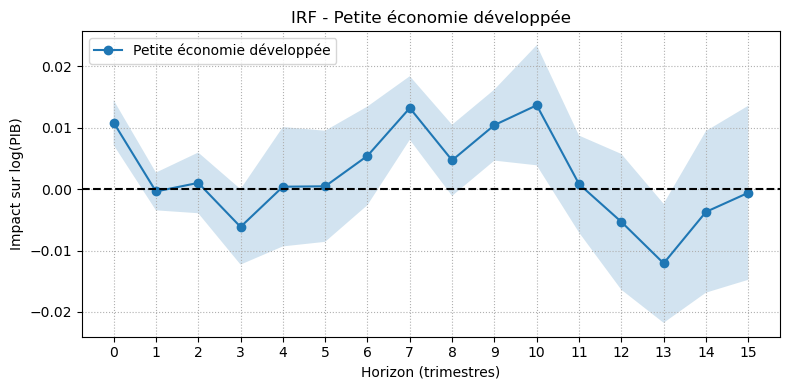

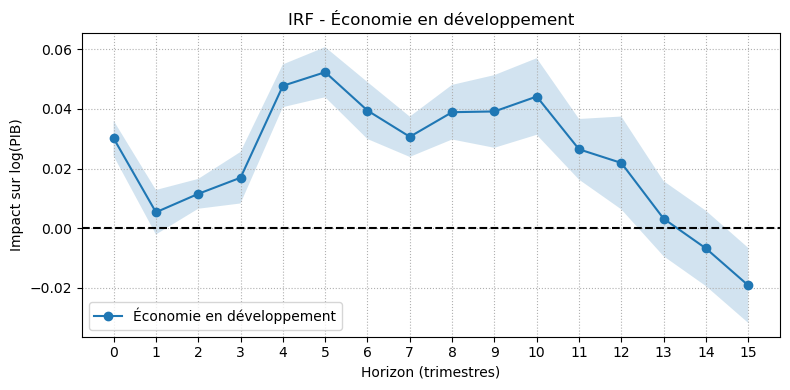

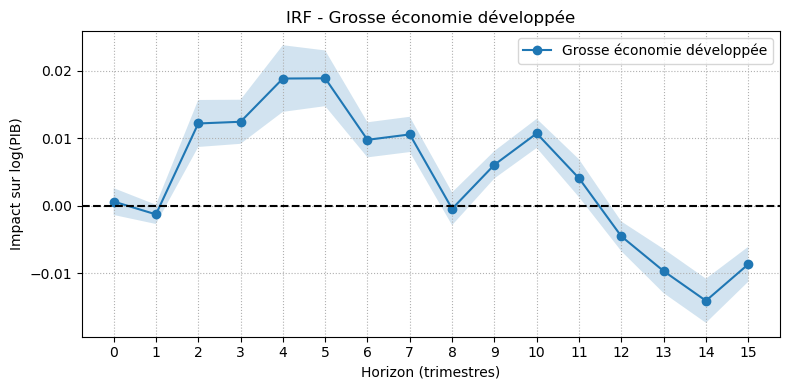

In [121]:
from linearmodels.panel import PanelOLS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Chocs monétaires US
df_shocks = data_US_clean.reset_index()[["date", "monetary_shocks_2lags_v3"]].copy()
df_shocks.columns = ["Time", "shock_US"]
df_shocks["Time"] = pd.PeriodIndex(df_shocks["Time"], freq="Q").to_timestamp()

# 2. Panel principal (data)
data["Time"] = pd.PeriodIndex(data["Time"].astype(str), freq="Q").to_timestamp()

# 3. Fusion
df_merged = pd.merge(data, df_shocks, on="Time", how="inner")

# 4. Filtrer sur le PIB + log
df_pib = df_merged[df_merged["Variable"] == "PIB"].copy()
df_pib = df_pib[df_pib["Value"] > 0]
df_pib["Value"] = np.log(df_pib["Value"])

# 5. Attribution des catégories
def get_category(country):
    for cat, countries in categories.items():
        if country in countries:
            return cat
    return "Autre"

df_pib["Category"] = df_pib["Country"].apply(get_category)

# 6. Projections locales par catégorie
H = 15
results = {}
for cat in df_pib["Category"].unique():
    betas, stderr = [], []
    df_cat = df_pib[df_pib["Category"] == cat].copy()
    df_cat = df_cat.sort_values(["Country", "Time"])
    df_cat = df_cat.set_index(["Country", "Time"])

    for h in range(H + 1):
        df_lp = df_cat.copy()
        df_lp[f"y_lead{h}"] = df_lp.groupby(level="Country")["Value"].shift(-h)
        for lag in range(1, 5):
            df_lp[f"y_lag{lag}"] = df_lp.groupby(level="Country")["Value"].shift(lag)

        df_lp = df_lp.reset_index()
        df_lp["trend"] = df_lp.groupby("Country").cumcount() + 1
        df_lp["trend_sq"] = df_lp["trend"] ** 2
        df_lp = df_lp.set_index(["Country", "Time"])

        needed = [f"y_lead{h}", "shock_US"] + [f"y_lag{k}" for k in range(1, 5)]
        df_model = df_lp.dropna(subset=needed).copy()
        if df_model.empty:
            betas.append(np.nan)
            stderr.append(np.nan)
            continue

        Y = df_model[f"y_lead{h}"]
        X_cols = ["shock_US", "y_lag1", "y_lag2", "y_lag3", "y_lag4", "trend", "trend_sq"]
        df_model["const"] = 1.0
        X = df_model[["const"] + X_cols]

        model = PanelOLS(dependent=Y, exog=X, entity_effects=True)
        res = model.fit(cov_type="clustered", cluster_entity=True)

        betas.append(res.params["shock_US"])
        stderr.append(res.std_errors["shock_US"])

    results[cat] = {
        "beta": np.array(betas),
        "stderr": np.array(stderr)
    }

# 7. Tracé IRF pour chaque catégorie
horizons = range(H + 1)
for cat, res_cat in results.items():
    beta, se = res_cat["beta"], res_cat["stderr"]
    lower, upper = beta - se, beta + se

    plt.figure(figsize=(8, 4))
    plt.plot(horizons, beta, marker='o', label=cat)
    plt.fill_between(horizons, lower, upper, alpha=0.2)
    plt.axhline(0, color='black', linestyle='--')
    plt.title(f"IRF - {cat}")
    plt.xlabel("Horizon (trimestres)")
    plt.ylabel("Impact sur log(PIB)")
    plt.grid(True, linestyle=':')
    plt.xticks(horizons)
    plt.legend()
    plt.tight_layout()
    plt.show()
